In [21]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import normalize
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings("ignore")


In [22]:
def train(X_train, X_test, y_test, y_train, number_of_class):
    '''
    We treat this as a regression problem, basically just treat the dataset as our label. 
    Spliting the decision tree based on the variance reduction rule.
    Returns the test dataset with assigned cluster index
    '''
    # Regression Decision Tree
    reg = DecisionTreeRegressor(criterion="squared_error", max_leaf_nodes=number_of_class)
    reg = reg.fit(X_train,X_train)
    y_pred = reg.predict(X_test) #values in y_pred are cluster centers!
    
    unique = np.unique(y_pred, axis=0) # a numpy array with only unique clusters
    
    # assign a cluster index to our prediction points
    cluster_index = np.zeros((y_pred.shape[0], )) 
    for i, cluster in enumerate(unique):
        for j, datapoint in enumerate(y_pred):
            if np.array_equal(datapoint, cluster):
                cluster_index[j] = int(i)
    return cluster_index
def get_population_in_cluster_i(number_of_class, y_test, cluster_index, cluster_i):
    '''
    This is function that returns the number of labels for cluster_i
    '''
    true_label, counts =  np.unique(y_test[np.where(np.array(cluster_index)==cluster_i)[0]], return_counts=True)
    #add dummy into counts 
    for i in range(number_of_class):
        if i not in true_label:
            counts = np.insert(counts, i , 0)
    return counts
def label_assign(y_test, cluster_index, number_of_class):
    '''
    Perform two accuracy measurements
    '''
    
    # Use the majority rule to assign a label to each cluster
    
    population_of_cluster = np.asmatrix([get_population_in_cluster_i(number_of_class, y_test, cluster_index, i) for i in range(number_of_class)])
    # Assigned label for each cluster
    labels = np.argmax(population_of_cluster,axis=1)
    labels_simple = []
    for i in np.asarray(labels):
        labels_simple.append(i[0])
#     print("When using the simple majority rule to assign a label to each cluster:")
#     for i, label in enumerate(labels_simple):
#         print("The label for cluster", i, "is:", label)
    
    # Majority Rule with assigned weight
    
    #precentage_in_cluster = normalize(population_of_cluster, axis=1, norm='l1')
    #print(precentage_in_cluster)
    precentage_in_label = normalize(population_of_cluster, axis=0, norm='l1')
    #print(precentage_in_label)
    score_matrix = np.multiply(population_of_cluster,precentage_in_label)
    #score_matrix
    norm_score = normalize(score_matrix, axis=1, norm='l1')
    labels_weight = np.argmax(norm_score, axis=1)
#     print("When using weighted majority rule to assign a label to each cluster:")
#     for i, label in enumerate(labels_weight):
#         print("The label for cluster", i, "is:", label)
    
    return labels_simple, labels_weight

def get_accuracy(cluster_new_label, cluster_index, y_test):
    labels = [cluster_new_label[int(ci)] for ci in cluster_index]
    return accuracy_score(y_test, labels)

In [23]:
datasets = ['Shoes']
features = ['raw', 'RGB', 'LBP_corner', 'raw_RGB', 'raw_LBP_corner', 'RGB_LBP_corner', 'raw_RGB_LBP_corner']

input_dir = "./supervised/final_results/"
output_dir = "./unsupervised_results/"

In [24]:
def load_data(dataset, feature):
    X_train = np.load(input_dir + dataset + "/" + feature + "/X_train_" + feature + ".npy")
    X_test = np.load(input_dir + dataset + "/" + feature + "/X_test_" + feature + ".npy")
    y_train = np.load(input_dir + dataset + "/" + feature + "/y_train_" + feature + ".npy")
    y_test = np.load(input_dir + dataset + "/" + feature + "/y_test_" + feature + ".npy")
    
    return X_train, X_test, y_train, y_test

In [25]:
def trim(X_test, y_test, number_of_class):
    temp_label = -1
    split_at_index = []
    for index, label in enumerate(y_test):
        if temp_label != label:
            #print("new label", label)
            temp_label = label
            split_at_index.append(index)

    label_size = [split_at_index[i+1] - split_at_index[i]for i in range(number_of_class-1)]
    label_size.append(len(y_test) - split_at_index[-1] )
    minimun = np.min(label_size)
    
    trim_y = np.concatenate([y_test[split_at_index[i]:(split_at_index[i]+minimun)] for i in range(number_of_class) ], axis=0)
    trim_x = np.concatenate([X_test[split_at_index[i]:(split_at_index[i]+minimun)] for i in range(number_of_class) ], axis=0)
    

    return trim_x, trim_y

In [26]:
def km(dataset, feature, X_train, X_test, y_train, y_test):
    # Wrapper function
    number_of_class = len(np.unique(y_test))
    kmeans = KMeans(n_clusters=number_of_class, random_state=0).fit(X_test)
    cluster_index = kmeans.predict(X_test)
    labels_simple, labels_weight = label_assign(y_test, cluster_index, number_of_class)

    accuracy_simple = get_accuracy(labels_simple, cluster_index, y_test)
    silhouette_avg = silhouette_score(X_test, cluster_index)
    # accuracy_weight = get_accuracy(labels_weight, cluster_index, y_test)
    return accuracy_simple, silhouette_avg

In [29]:
accuracy_kmeans = []
silhouette_avgs_kmeans = []
for dataset in datasets:
    for feature in features:
        X_train, X_test, y_train, y_test = load_data(dataset, feature)
        X_test, y_test = trim(X_test, y_test, len(np.unique(y_test)))
        accuracy_simple, silhouette_avg = km(dataset, feature, X_train, X_test, y_train, y_test)
        accuracy_kmeans.append(accuracy_simple)
        silhouette_avgs_kmeans.append(silhouette_avg)

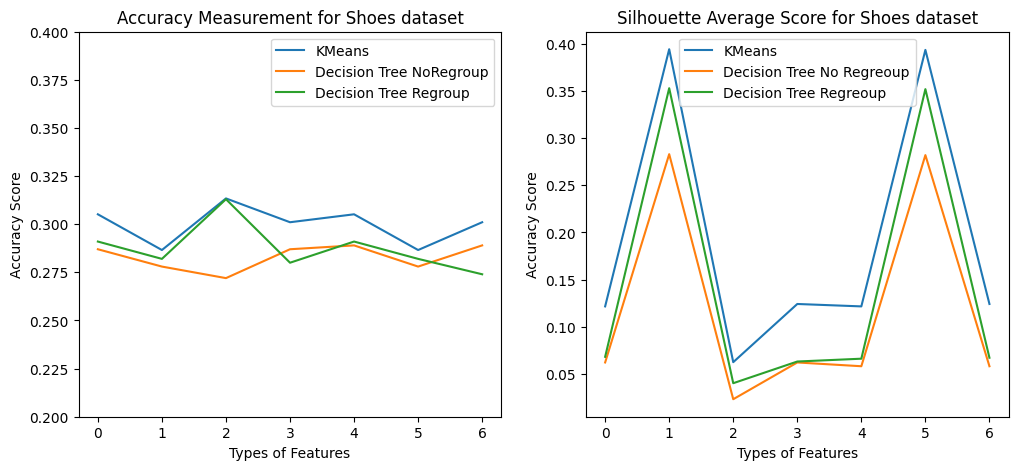

In [32]:
accuracy_noregroup = [0.287, 0.278, 0.272, 0.287, 0.289, 0.278, 0.289]
silhouette_noregroup = [0.062, 0.283, 0.023, 0.062, 0.058, 0.282, 0.058]
accuracy_regroup = [0.291, 0.282, 0.313, 0.28, 0.291, 0.282, 0.274]
silhouette_regroup = [0.068, 0.353, 0.04, 0.063, 0.066, 0.352, 0.067]
nn = [0.25349794238683127, 0.297119341563786, 0.28888, 0.254320987654321,
     0.31522633744855966, 0.24526748971193416]

feature_names = ["raw", "RGB", "LBP_corner", "raw_RGB", "raw_LBP_corner", 
                 "RGB_LBP_corner", "raw_RGB_LBP_corner"]

# Comapre Performance between KMeans and Decision Tree

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
axes[0].plot(accuracy_kmeans, label = "KMeans")
axes[0].plot(accuracy_noregroup, label = "Decision Tree NoRegroup")
axes[0].plot(accuracy_regroup, label = "Decision Tree Regroup")
# axes[0].plot(nn, label = "NeuralNet")
axes[0].set_ylim(ymin=0.2, ymax=0.4)
axes[0].set_xlabel("Types of Features")
axes[0].set_ylabel("Accuracy Score")
axes[0].set_title("Accuracy Measurement for Shoes dataset")
axes[0].legend()

axes[1].plot(silhouette_avgs_kmeans, label = "KMeans")
axes[1].plot(silhouette_noregroup, label = "Decision Tree No Regreoup")
axes[1].plot(silhouette_regroup, label = "Decision Tree Regreoup")
#axes[1].set_ylim(ymin=0.3, ymax=0.4)
axes[1].set_xlabel("Types of Features")
axes[1].set_ylabel("Accuracy Score")
axes[1].set_title("Silhouette Average Score for Shoes dataset")
axes[1].legend()

